# Import

In [8]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sklearn.metrics import confusion_matrix, multilabel_confusion_matrix, classification_report

# Enable GPU

In [9]:
gpus = tf.config.list_physical_devices('GPU')
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        pass

Num GPUs Available:  1


# Load data

In [10]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.mnist.load_data()

# Dataset Analysis

In [11]:
# Print some information about the dataset
print(f"The shape of the training data is: {X_train.shape}")
print(f"The shape of the testing data is: {X_test.shape}")
print(f"The shape of the training labels is: {y_train.shape}")
print(f"The shape of the testing labels is: {y_test.shape}")

The shape of the training data is: (60000, 28, 28)
The shape of the testing data is: (10000, 28, 28)
The shape of the training labels is: (60000,)
The shape of the testing labels is: (10000,)


## Create Dataframes

In [12]:
# Create a dataframe from the training data
train_df = pd.DataFrame.from_records(X_train.reshape(-1, 28*28))

# Add the labels to the dataframe
train_df['label'] = y_train

In [13]:
# Display the first 5 rows of the training data
train_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,5
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,9


In [14]:
# Create a dataframe from the testing data
test_df = pd.DataFrame.from_records(X_test.reshape(-1, 28*28))

# Add the labels to the dataframe
test_df['label'] = y_test

In [15]:
# Display the first 5 rows of the testing data
test_df.head()

,0,1,2,3,4,5,6,7,8,9,...,775,776,777,778,779,780,781,782,783,label
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,7
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,4


## Plot the number of samples

1    6742
7    6265
3    6131
2    5958
9    5949
0    5923
6    5918
8    5851
4    5842
5    5421
Name: label, dtype: int64

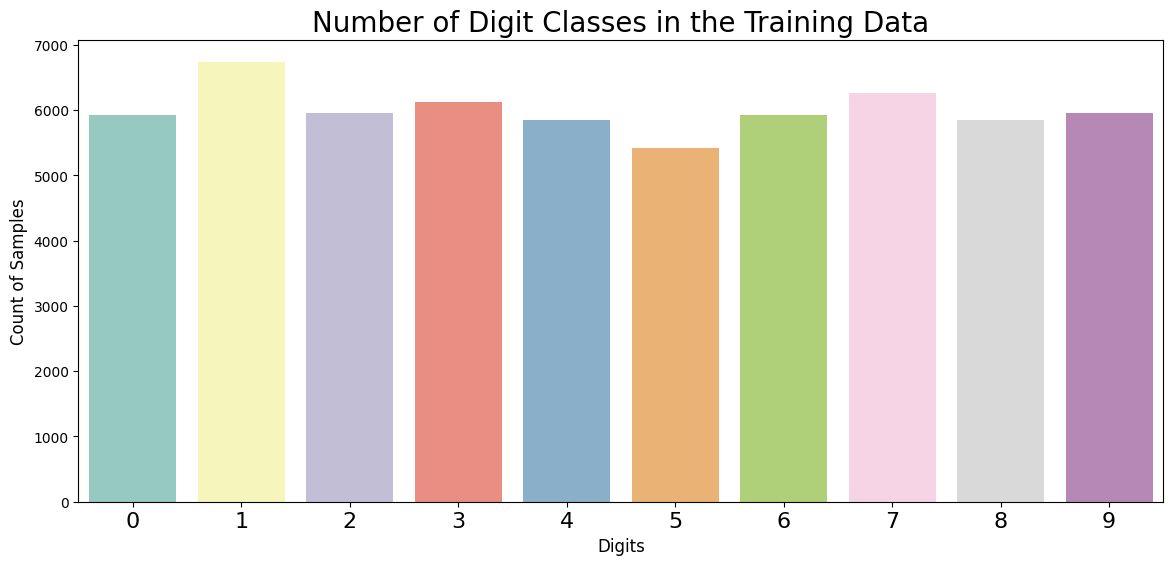

In [16]:
# Plot the number of samples for each digit class in the training data
plt.figure(figsize=(14, 6))
g = sns.countplot(x=train_df['label'], palette = 'Set3')
plt.title("Number of Digit Classes in the Training Data", size = 20)
plt.xticks(size = 16)
plt.xlabel("Digits", size = 12)
plt.ylabel("Count of Samples", size = 12)
train_df['label'].value_counts()

1    1135
2    1032
7    1028
3    1010
9    1009
4     982
0     980
8     974
6     958
5     892
Name: label, dtype: int64

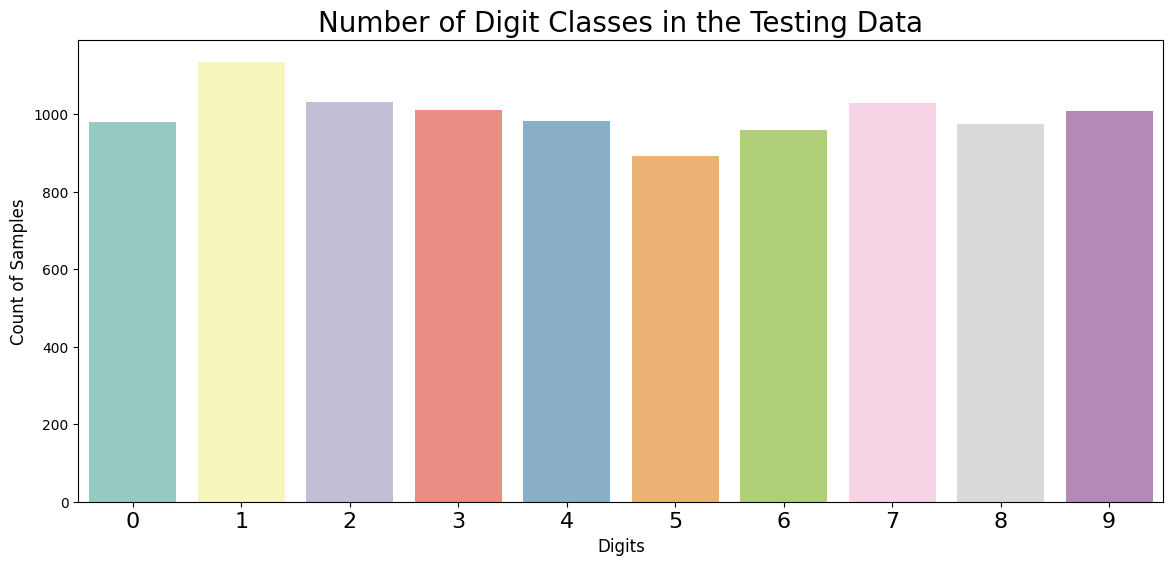

In [17]:
# Plot the number of samples for each digit class in the testing data
plt.figure(figsize=(14, 6))
g = sns.countplot(x=test_df['label'], palette = 'Set3')
plt.title("Number of Digit Classes in the Testing Data", size = 20)
plt.xticks(size = 16)
plt.xlabel("Digits", size = 12)
plt.ylabel("Count of Samples", size = 12)
test_df['label'].value_counts()

## Plot random samples from dataset

A random sample of 20 images from the training data


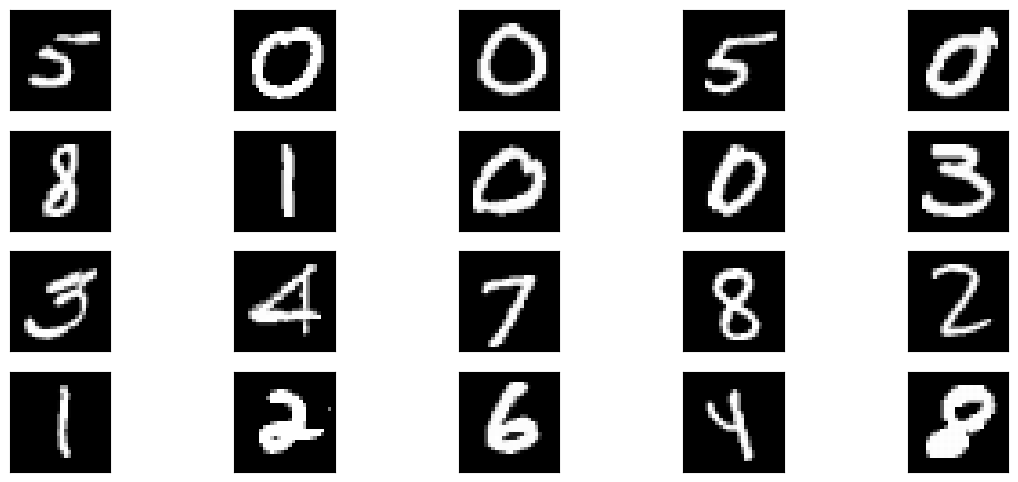

In [18]:
# Plot random some samples from the training data
rows, cols = 4, 5
print(f"A random sample of {rows*cols} images from the training data")
fig, ax = plt.subplots(rows, cols, figsize=(14, 6))
for i in range(rows):
    for j in range(cols):
        ax[i, j].imshow(X_train[random.randint(0, len(X_test))], cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.show()

A random sample of 20 images from the testing data


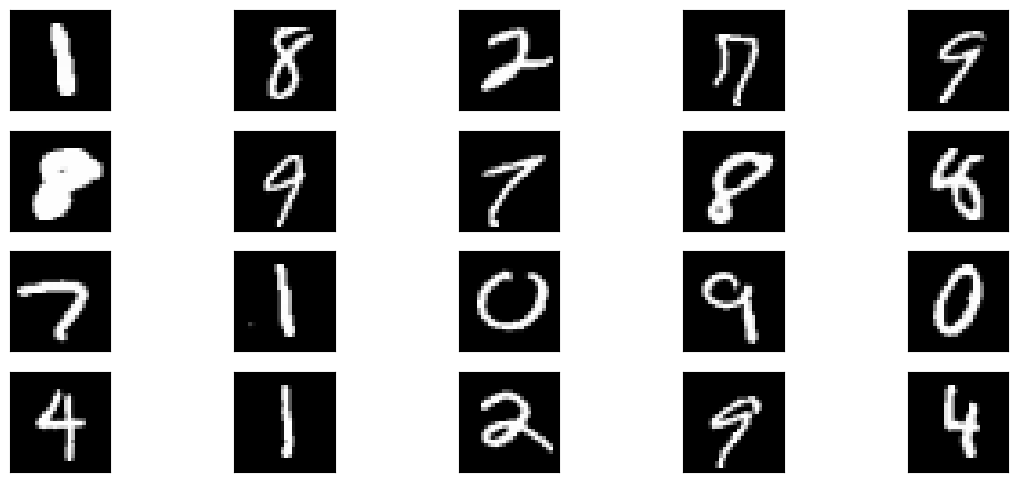

In [19]:
# Plot random some samples from the testing data
rows, cols = 4, 5
print(f"A random sample of {rows*cols} images from the testing data")
fig, ax = plt.subplots(rows, cols, figsize=(14, 6))
for i in range(rows):
    for j in range(cols):
        ax[i, j].imshow(X_test[random.randint(0, len(X_test))], cmap='gray')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
plt.show()

# Data pre-processing

In [20]:
# Normalize the data
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255

# Convert the labels to one-hot encoding
y_train = tf.keras.utils.to_categorical(y_train)
y_test = tf.keras.utils.to_categorical(y_test)

# Build & Compile model

## Model before enhancements

### Load model

In [21]:
# Load the model
load = False
if load:
    model1 = tf.keras.models.load_model('../mnist_rnn_before_enhancement.h5')

### Build model

In [22]:
def build_model(shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(units=32, input_shape=(shape), activation='tanh', return_sequences=True),
        tf.keras.layers.SimpleRNN(units=16, activation='tanh'),
        tf.keras.layers.Dense(units=10),
        tf.keras.layers.Activation('softmax'),
    ])
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

model1 = build_model(X_train[0].shape)

model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn (SimpleRNN)      (None, 28, 32)            1952      
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 16)                784       
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 activation (Activation)     (None, 10)                0         
                                                                 
Total params: 2,906
Trainable params: 2,906
Non-trainable params: 0
_________________________________________________________________


2023-04-25 20:21:53.661790: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 20:21:54.649912: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 4657 MB memory:  -> device: 0, name: NVIDIA GeForce GTX 1660 Ti, pci bus id: 0000:01:00.0, compute capability: 7.5


### Model fit

In [23]:
epochs = 10
batch_size = 16

history1 = model1.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=batch_size)

loss, accuracy = model1.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

print(f"Loss: {loss*100:.2f}%")
print(f"Accuracy: {accuracy*100:.2f}%\n")

2023-04-25 20:21:54.924757: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150528000 exceeds 10% of free system memory.
2023-04-25 20:21:55.112524: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150528000 exceeds 10% of free system memory.


Epoch 1/10
3000/3000 [==============================] - 72s 23ms/step - loss: 0.7907 - accuracy: 0.7529 - val_loss: 0.4594 - val_accuracy: 0.8578
Epoch 2/10
3000/3000 [==============================] - 71s 24ms/step - loss: 0.4261 - accuracy: 0.8712 - val_loss: 0.3579 - val_accuracy: 0.8967
Epoch 3/10
3000/3000 [==============================] - 67s 22ms/step - loss: 0.3643 - accuracy: 0.8925 - val_loss: 0.2929 - val_accuracy: 0.9154
Epoch 4/10
3000/3000 [==============================] - 72s 24ms/step - loss: 0.3373 - accuracy: 0.9012 - val_loss: 0.2828 - val_accuracy: 0.9185
Epoch 5/10
3000/3000 [==============================] - 68s 23ms/step - loss: 0.3209 - accuracy: 0.9064 - val_loss: 0.3180 - val_accuracy: 0.9077
Epoch 6/10
3000/3000 [==============================] - 68s 23ms/step - loss: 0.2926 - accuracy: 0.9153 - val_loss: 0.2371 - val_accuracy: 0.9334
Epoch 7/10
3000/3000 [==============================] - 69s 23ms/step - loss: 0.2802 - accuracy: 0.9199 - val_loss: 0.2787 -

### Save model

In [24]:
save = True
if save:
    model1.save('../mnist_rnn_before_enhancement.h5')

## Model after enhancements

### Load model

In [25]:
# Load the model
load = False
if load:
    model2 = tf.keras.models.load_model('../mnist_rnn.h5')

### Build model

In [26]:
def build_model(shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(units=256, dropout=0.2, input_shape=(shape), activation='relu', return_sequences=True),
        tf.keras.layers.SimpleRNN(units=128, activation='relu'),
        tf.keras.layers.Dense(units=10),
        tf.keras.layers.Activation('softmax'),
    ])
    model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
    return model

model2 = build_model(X_train[0].shape)

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_2 (SimpleRNN)    (None, 28, 256)           72960     
                                                                 
 simple_rnn_3 (SimpleRNN)    (None, 128)               49280     
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
 activation_1 (Activation)   (None, 10)                0         
                                                                 
Total params: 123,530
Trainable params: 123,530
Non-trainable params: 0
_________________________________________________________________


### Model fit

In [27]:
epochs = 20
batch_size = 64

history2 = model2.fit(X_train, y_train, epochs=epochs, validation_split=0.2, batch_size=batch_size)

loss, accuracy = model2.evaluate(X_test, y_test, batch_size=batch_size, verbose=0)

print(f"Loss: {loss*100:.2f}%")
print(f"Accuracy: {accuracy*100:.2f}%\n")

Epoch 1/20


2023-04-25 20:33:27.402588: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150528000 exceeds 10% of free system memory.
2023-04-25 20:33:27.537149: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 150528000 exceeds 10% of free system memory.


750/750 [==============================] - 21s 27ms/step - loss: 0.9859 - accuracy: 0.6589 - val_loss: 0.4207 - val_accuracy: 0.8619
Epoch 2/20
750/750 [==============================] - 20s 27ms/step - loss: 0.3104 - accuracy: 0.9043 - val_loss: 0.1663 - val_accuracy: 0.9492
Epoch 3/20
750/750 [==============================] - 20s 26ms/step - loss: 0.1953 - accuracy: 0.9397 - val_loss: 0.1346 - val_accuracy: 0.9598
Epoch 4/20
750/750 [==============================] - 19s 26ms/step - loss: 0.1477 - accuracy: 0.9548 - val_loss: 0.1085 - val_accuracy: 0.9691
Epoch 5/20
750/750 [==============================] - 20s 26ms/step - loss: 0.1231 - accuracy: 0.9612 - val_loss: 0.0847 - val_accuracy: 0.9742
Epoch 6/20
750/750 [==============================] - 20s 26ms/step - loss: 0.1049 - accuracy: 0.9679 - val_loss: 0.0868 - val_accuracy: 0.9726
Epoch 7/20
750/750 [==============================] - 19s 26ms/step - loss: 0.0949 - accuracy: 0.9705 - val_loss: 0.0719 - val_accuracy: 0.9780
Epo

### Save model

In [28]:
save = True
if save:
    model2.save('../mnist_rnn.h5')

# Plots and tests

## Model before enhancements

### Model predict 

In [29]:
y_pred1 = model1.predict(X_test)
y_pred_classes1 = np.argmax(y_pred1, axis=1)
y_true = np.argmax(y_test, axis=1)

### Loss and accuracy curves

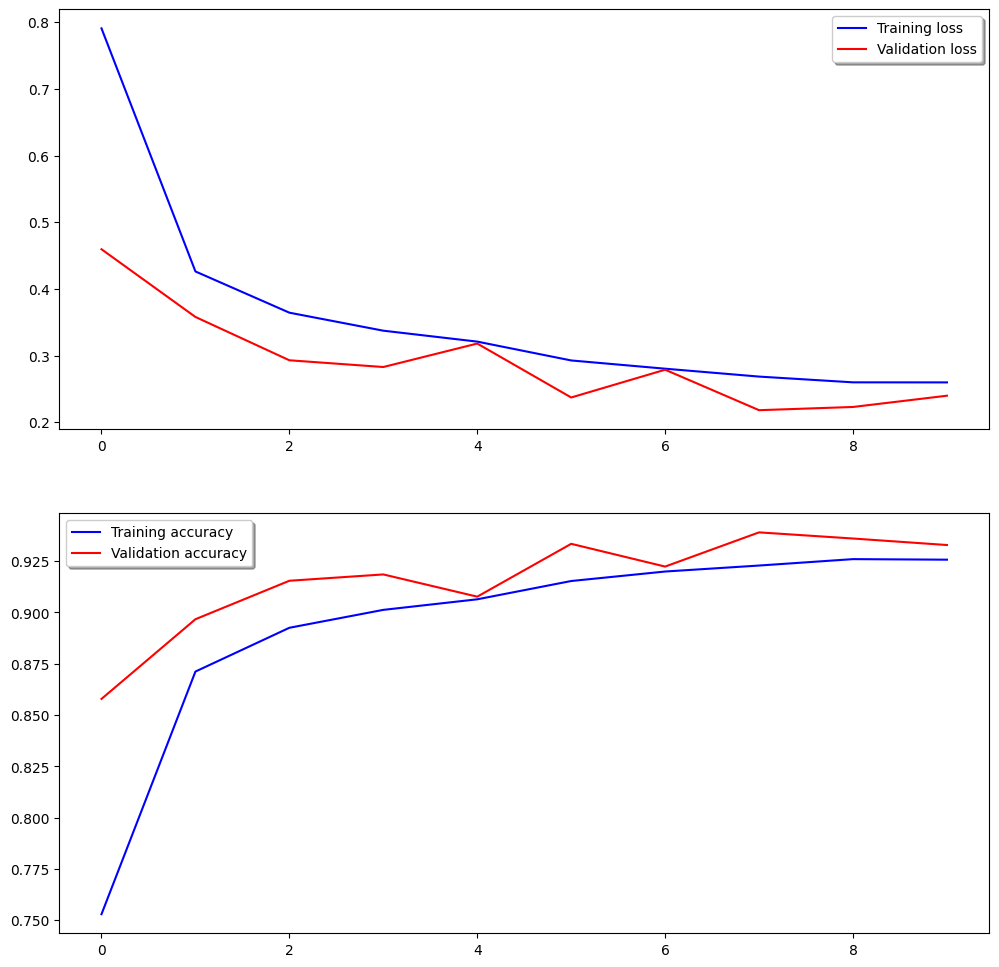

In [30]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(history1.history['loss'], color='b', label="Training loss")
ax[0].plot(history1.history['val_loss'], color='r', label="Validation loss", axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history1.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history1.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion matrix

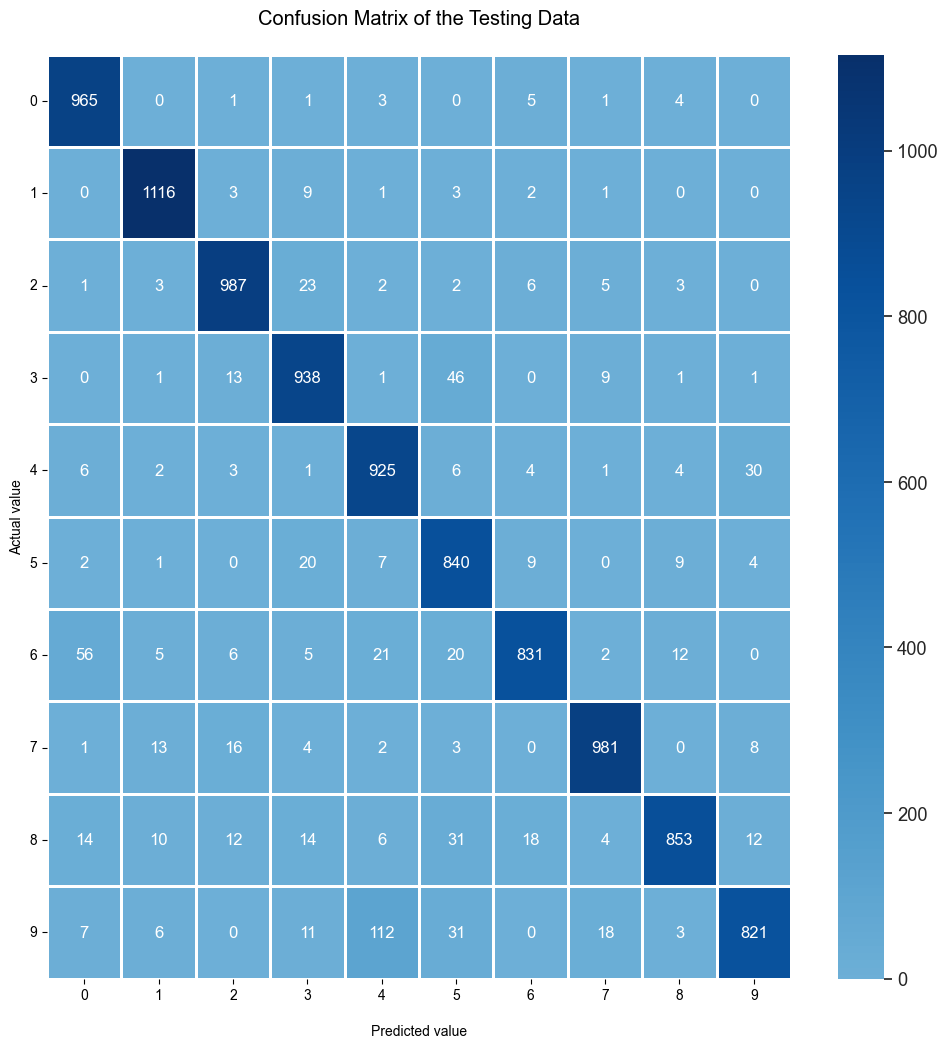

In [31]:
# Plot the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes1)
f, ax = plt.subplots(figsize=(12, 12))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx, annot=True, linewidths=1, annot_kws={"size": 12}, center=10.0, cmap="Blues", ax=ax, fmt='g')
ax.set(title="Confusion Matrix of the Testing Data\n",
      xlabel="\nPredicted value",
      ylabel="Actual value")
ax.set_xticklabels(labels=range(10), rotation=0, horizontalalignment='center', verticalalignment='top')
ax.set_yticklabels(labels=range(10), rotation=0, horizontalalignment='right', verticalalignment='center')
plt.show()

In [32]:
# Print the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_classes1)

for i, matrix in zip(range(10), confusion_matrices):
    print(f"Class {i}:")
    print(f"True Positive(TP): {matrix[1][1]} - False Positive(FP): {matrix[0][1]}")
    print(f"False Negative(FN): {matrix[1][0]} - True Negative(TN): {matrix[0][0]}")
    print("----------------------------------------------------")

Class 0:
True Positive(TP): 965 - False Positive(FP): 87
False Negative(FN): 15 - True Negative(TN): 8933
----------------------------------------------------
Class 1:
True Positive(TP): 1116 - False Positive(FP): 41
False Negative(FN): 19 - True Negative(TN): 8824
----------------------------------------------------
Class 2:
True Positive(TP): 987 - False Positive(FP): 54
False Negative(FN): 45 - True Negative(TN): 8914
----------------------------------------------------
Class 3:
True Positive(TP): 938 - False Positive(FP): 88
False Negative(FN): 72 - True Negative(TN): 8902
----------------------------------------------------
Class 4:
True Positive(TP): 925 - False Positive(FP): 155
False Negative(FN): 57 - True Negative(TN): 8863
----------------------------------------------------
Class 5:
True Positive(TP): 840 - False Positive(FP): 142
False Negative(FN): 52 - True Negative(TN): 8966
----------------------------------------------------
Class 6:
True Positive(TP): 831 - False Pos

### Classification report

In [33]:
# Plot the classification report
target_names = [f"Class {i}" for i in range(10)]
print(classification_report(y_true, y_pred_classes1, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.92      0.98      0.95       980
     Class 1       0.96      0.98      0.97      1135
     Class 2       0.95      0.96      0.95      1032
     Class 3       0.91      0.93      0.92      1010
     Class 4       0.86      0.94      0.90       982
     Class 5       0.86      0.94      0.90       892
     Class 6       0.95      0.87      0.91       958
     Class 7       0.96      0.95      0.96      1028
     Class 8       0.96      0.88      0.92       974
     Class 9       0.94      0.81      0.87      1009

    accuracy                           0.93     10000
   macro avg       0.93      0.92      0.92     10000
weighted avg       0.93      0.93      0.93     10000



### Test the model

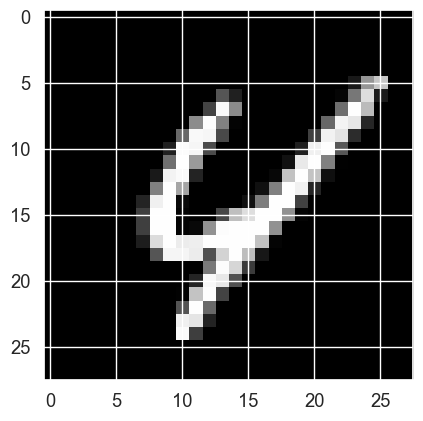

The image above is: 4
The model predicted: 4


In [63]:
# Test the model with a random image from the test dataset
i = random.randint(0, X_test.shape[0])
plt.imshow(X_test[i], cmap='gray')
plt.show()
print(f"The image above is: {np.argmax(y_test[i])}")

# Predict the class of the image
pred = model1.predict(X_test[i].reshape(1, 28, 28))
print(f"The model predicted: {pred.argmax()}")

## Model after enhancements

### Model predict 

In [35]:
y_pred2 = model2.predict(X_test)
y_pred_classes2 = np.argmax(y_pred2, axis=1)
y_true = np.argmax(y_test, axis=1)

### Loss and accuracy curves

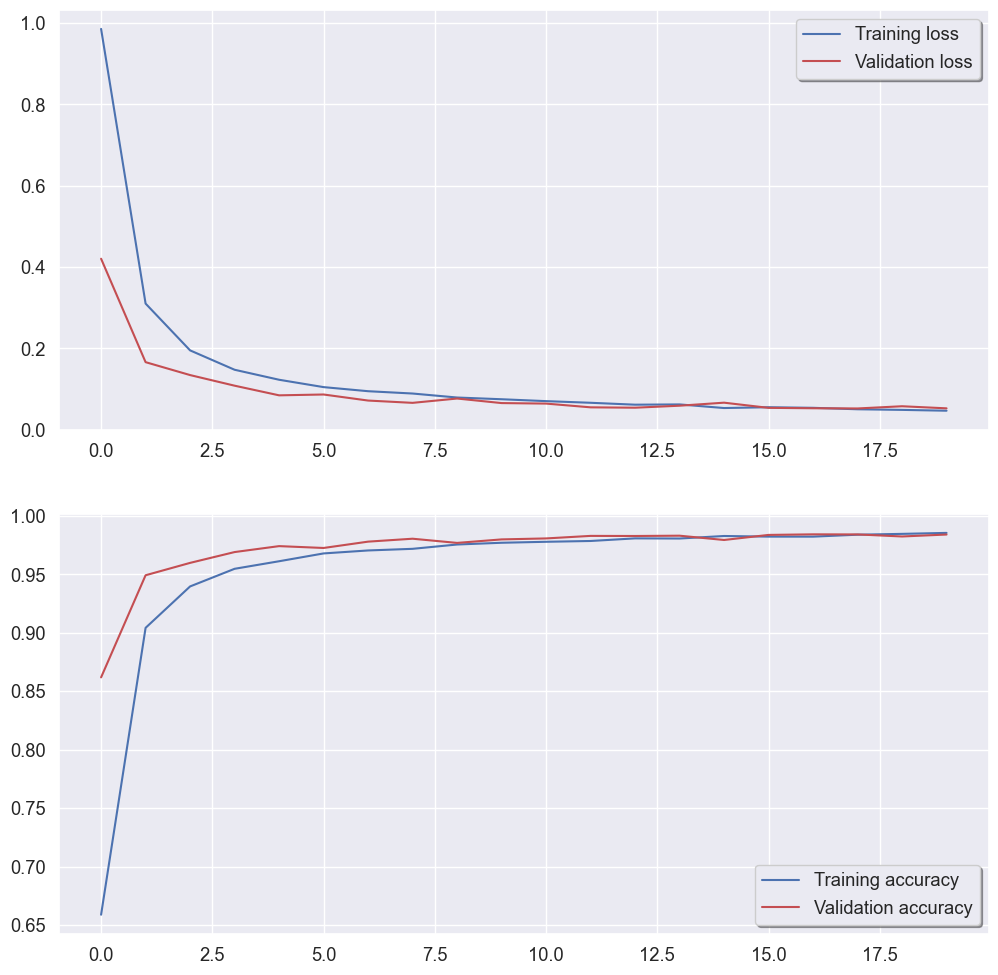

In [36]:
# Plot the loss and accuracy curves for training and validation
fig, ax = plt.subplots(2, 1, figsize=(12, 12))
ax[0].plot(history2.history['loss'], color='b', label="Training loss")
ax[0].plot(history2.history['val_loss'], color='r', label="Validation loss", axes =ax[0])
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(history2.history['accuracy'], color='b', label="Training accuracy")
ax[1].plot(history2.history['val_accuracy'], color='r',label="Validation accuracy")
legend = ax[1].legend(loc='best', shadow=True)

### Confusion matrix

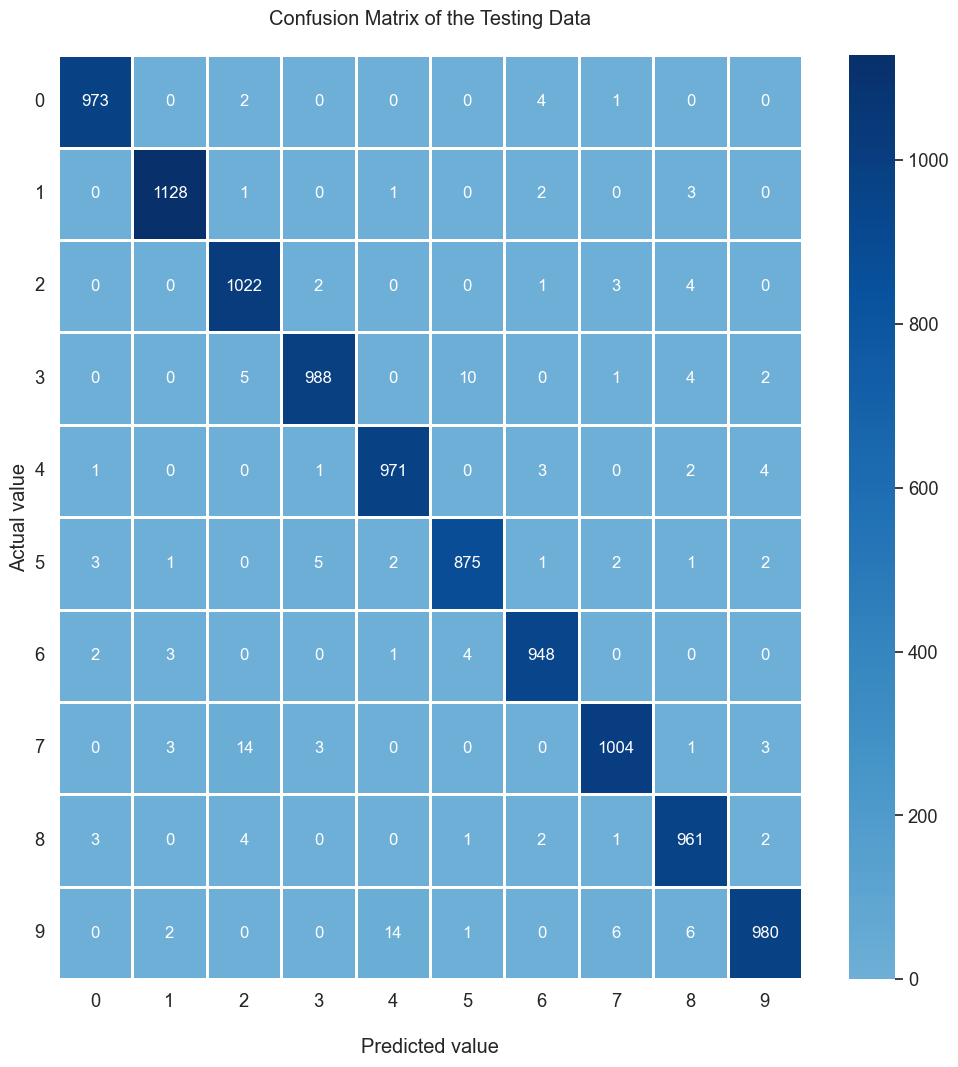

In [37]:
# Plot the confusion matrix
confusion_mtx = confusion_matrix(y_true, y_pred_classes2)
f, ax = plt.subplots(figsize=(12, 12))
sns.set(font_scale=1.2)
sns.heatmap(confusion_mtx, annot=True, linewidths=1, annot_kws={"size": 12}, center=10.0, cmap="Blues", ax=ax, fmt='g')
ax.set(title="Confusion Matrix of the Testing Data\n",
      xlabel="\nPredicted value",
      ylabel="Actual value")
ax.set_xticklabels(labels=range(10), rotation=0, horizontalalignment='center', verticalalignment='top')
ax.set_yticklabels(labels=range(10), rotation=0, horizontalalignment='right', verticalalignment='center')
plt.show()

In [38]:
# Print the multilabel confusion matrix
confusion_matrices = multilabel_confusion_matrix(y_true, y_pred_classes2)

for i, matrix in zip(range(10), confusion_matrices):
    print(f"Class {i}:")
    print(f"True Positive(TP): {matrix[1][1]} - False Positive(FP): {matrix[0][1]}")
    print(f"False Negative(FN): {matrix[1][0]} - True Negative(TN): {matrix[0][0]}")
    print("----------------------------------------------------")

Class 0:
True Positive(TP): 973 - False Positive(FP): 9
False Negative(FN): 7 - True Negative(TN): 9011
----------------------------------------------------
Class 1:
True Positive(TP): 1128 - False Positive(FP): 9
False Negative(FN): 7 - True Negative(TN): 8856
----------------------------------------------------
Class 2:
True Positive(TP): 1022 - False Positive(FP): 26
False Negative(FN): 10 - True Negative(TN): 8942
----------------------------------------------------
Class 3:
True Positive(TP): 988 - False Positive(FP): 11
False Negative(FN): 22 - True Negative(TN): 8979
----------------------------------------------------
Class 4:
True Positive(TP): 971 - False Positive(FP): 18
False Negative(FN): 11 - True Negative(TN): 9000
----------------------------------------------------
Class 5:
True Positive(TP): 875 - False Positive(FP): 16
False Negative(FN): 17 - True Negative(TN): 9092
----------------------------------------------------
Class 6:
True Positive(TP): 948 - False Positive

### Classification report

In [39]:
# Plot the classification report
target_names = [f"Class {i}" for i in range(10)]
print(classification_report(y_true, y_pred_classes2, target_names=target_names))

              precision    recall  f1-score   support

     Class 0       0.99      0.99      0.99       980
     Class 1       0.99      0.99      0.99      1135
     Class 2       0.98      0.99      0.98      1032
     Class 3       0.99      0.98      0.98      1010
     Class 4       0.98      0.99      0.99       982
     Class 5       0.98      0.98      0.98       892
     Class 6       0.99      0.99      0.99       958
     Class 7       0.99      0.98      0.98      1028
     Class 8       0.98      0.99      0.98       974
     Class 9       0.99      0.97      0.98      1009

    accuracy                           0.98     10000
   macro avg       0.98      0.98      0.98     10000
weighted avg       0.99      0.98      0.98     10000



### Test the model

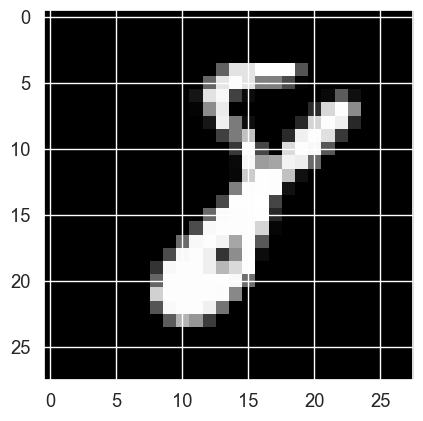

The image above is: 8
The model predicted: 8


In [40]:
# Test the model with a random image from the test dataset
i = random.randint(0, X_test.shape[0])
plt.imshow(X_test[i], cmap='gray')
plt.show()
print(f"The image above is: {np.argmax(y_test[i])}")

# Predict the class of the image
pred = model2.predict(X_test[i].reshape(1, 28, 28))
print(f"The model predicted: {pred.argmax()}")